In [39]:
import numpy as np
from tqdm.notebook import tqdm, trange # progress bars
import time
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device=", device)

device= cuda


Let's first do MNIST in PyTorch as a starting point.

In [62]:
# Data Loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_train = datasets.MNIST(root='./',
                             download=True,
                             train=True,
                             transform=transform)
mnist_test = datasets.MNIST(root='.',
                            download=False,
                            train=False,
                            transform=transform)

batch_size = 16
train_loader = DataLoader(mnist_train,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=2,
                        drop_last=True)
test_loader = DataLoader(mnist_test,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=2,
                        drop_last=True)

This is a 5


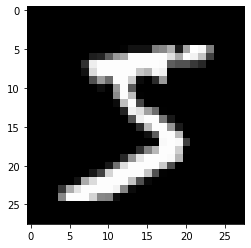

In [123]:
plt.imshow(mnist_train[0][0].reshape(28, 28), cmap="gray")
print("This is a {}".format(mnist_train.targets[0].numpy()))

In [63]:
def train(model, device, train_loader, batch_size, epochs):
    
    model.train()
    accuracies, losses = [], []
    
    criterion = nn.CrossEntropyLoss()#nn.NLLLoss(reduction='none')#
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
    
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, target in tepoch:
                
                data = data.reshape((batch_size, 28*28))
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                maxit = torch.argmax(output, dim=1)
                accuracy = (maxit==target).float().mean()
                
                loss = criterion(output, target)
                loss = loss
                losses.append(loss.item())
                accuracies.append(accuracy.item())
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss = loss.item())

    return losses, accuracies

def test(model, device, data_loader, num_labels, batch_size):
    
    model.eval()
    correct, total = np.zeros(num_labels), np.zeros(num_labels)
    
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.reshape((batch_size, 28*28))
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        
        outputs = model(inputs)
        _,prediction = torch.max(outputs, 1)
        
        for i in range(num_labels):
            relevant = (labels==i)
            total[i] += relevant.sum().item()
            correct[i] += (prediction[relevant] == labels[relevant]).sum().item()
            
    return correct, total

class cheater_net(nn.Module):
    def __init__(self):
        super(cheater_net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128, bias=False)
        self.fc2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.sm(x)
        return x

In [66]:
cheater = cheater_net().to(device)
losses,accuracies = train(cheater, device, train_loader, batch_size, 5)

  0%|          | 0/3750 [00:00<?, ?batch/s]

  0%|          | 0/3750 [00:00<?, ?batch/s]

  0%|          | 0/3750 [00:00<?, ?batch/s]

  0%|          | 0/3750 [00:00<?, ?batch/s]

  0%|          | 0/3750 [00:00<?, ?batch/s]

accuracy:0.9717


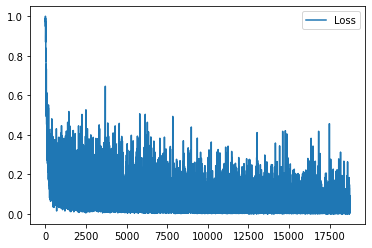

In [67]:
#plt.plot(accuracies, label="Accuracy")
plt.plot(losses/np.max(losses), label="Loss")
plt.legend()

num_labels = mnist_test.targets.unique().numel()
correct, total = test(cheater, device, test_loader, num_labels, batch_size)
print("accuracy:{}".format(correct.sum()/total.sum()))

# NumPy Only

Things we need

- Forward pass
- Backprop
- Loss function
- ReLU

### BackProp

**Crossentropy Cost, Softmax and derivatis**

$o^x_j:$ predicted probability of $x$ belonging to class $j$

$ t^x_j:$ target value of $x$ for output neuron $j$

Error $\large E_X = - \sum_k \left[ t_k^x \log(o_k^x) + (1-t_k^x) \log(1-o_k^x) \right]$

$\large \frac{\partial E_X}{\partial o_j^x} = -\frac{t_j^x}{o_j^x} + \frac{1 - t^x_j}{1-o_j^x}$

LogSoftMax derivative $\large \frac{\partial LS}{z} = 1 - e^{LSM(z)}$

In [38]:
class MLP:
    
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.W1 = np.random.randn(input_size, hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size)
        
    def forward(self):
        self.x = np.dot(self.x, self.W1)
        self.x = self.relu(self.x)
        self.x = np.dot(self.W1, self.W2)
        self.x = self.softmax(self.x)
        
    def logSoftmax(self, d, g=1):
        return np.log( np.exp(d*g) / np.sum(np.exp(d*g)) )
    
    def relu(self, x):
        return np.maximum(x, 1)
    
    def crossEntropyLoss(self, x, y):
        """
        y: binary indicator for class-identity
        x: predicted probability observations belong to class
        """
        return -np.sum(y * np.log(x))
    
    